In [2]:
!pip install scrapy
!pip install requests
!pip install selenium
import numpy as np
import pandas as pd
import scrapy
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
import pmdarima as pm
!pip install plotly
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
# !pip install -U keras-tuner
# import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
!pip install arch
from arch import arch_model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 11.7 MB/s eta 0:00:00


## PE Ratio

In [15]:
# Fetch the data
url = 'https://www.macrotrends.net/stocks/charts/NVDA/nvidia/pe-ratio'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df[1:]
df = df.rename(columns={0: 'Date', 1: 'Price', 2: 'EPS', 3: 'PE ratio'})
df.set_index('Date', inplace=True)
df = df.iloc[1:len(df['EPS'])-2, :]
df['PE ratio'] = df['PE ratio'].astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['EPS'])
df.head()

,Date,Price,EPS,PE ratio
0,2010-04-30,0.36,$0.12,3.14
1,2010-07-31,0.21,$0.10,2.11
2,2010-10-31,0.28,$0.09,3.07
3,2011-01-31,0.55,$0.10,5.36
4,2011-04-30,0.46,$0.10,4.59


                                Date   PE ratio
count                             57  57.000000
mean   2017-04-30 20:37:53.684210432   4.290351
min              2010-04-30 00:00:00   1.260000
25%              2013-10-31 00:00:00   1.980000
50%              2017-04-30 00:00:00   3.420000
75%              2020-10-31 00:00:00   5.380000
max              2024-04-30 00:00:00  14.450000
std                              NaN   2.974352


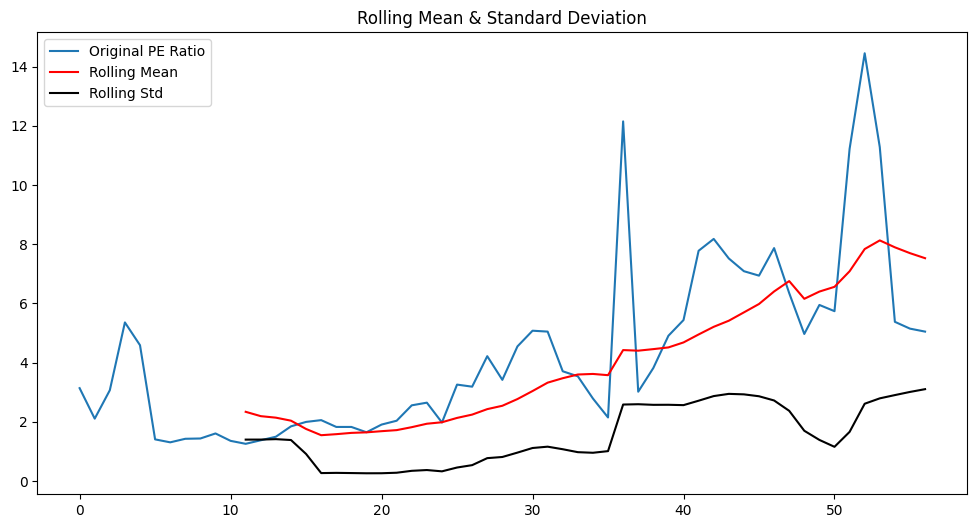

In [18]:
# EDA
# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['PE ratio'].rolling(window=rolling_window).mean()
rolling_std = df['PE ratio'].rolling(window=rolling_window).std()

plt.plot(df['PE ratio'], label='Original PE Ratio')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

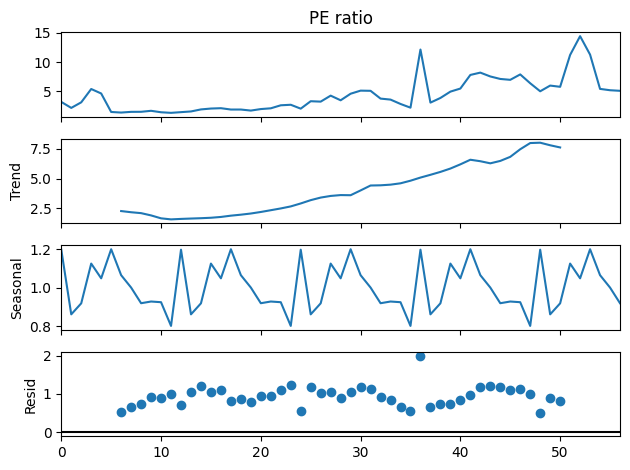

In [19]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['PE ratio'], model='multiplicative', period=12)
result.plot()
plt.show()

In [20]:
# Check for stationarity
result = adfuller(df['PE ratio'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')


ADF Statistic: -0.04723052648447929
p-value: 0.9544474590427092
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


In [21]:
# Difference the series to make it stationary
df['PE ratio diff'] = df['PE ratio'].diff().dropna()
result = adfuller(df['PE ratio diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -5.710073886969232
p-value: 7.334242039099264e-07
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


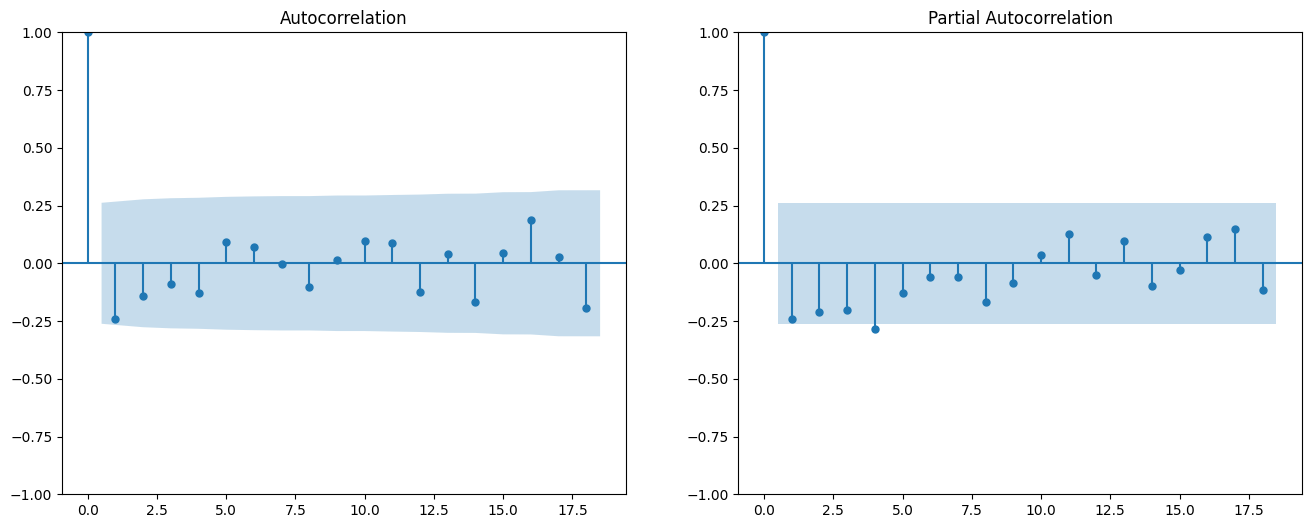

In [22]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['PE ratio diff'].dropna(), ax=axes[0])
plot_pacf(df['PE ratio diff'].dropna(), ax=axes[1])
plt.show()

In [23]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [24]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=206.313, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=197.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186.934, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=204.415, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=188.910, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=188.903, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=189.351, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=186.869, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=188.803, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=188.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=195.736, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=187.648, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.785 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -91.434
Date:                Thu, 18 Jul 2024   AIC                            186.869
Time:                        14:19:10   BIC                            190.526
Sample:                             0   HQIC                           188.239
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7011      0.121     -5.781      0.000      -0.939      -0.463
sigma2         3.0735      0.299     10.264      0.000       2.487       3.660
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               304.90
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               5.31   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best model ARIMA(0,1,1)

> Add blockquote



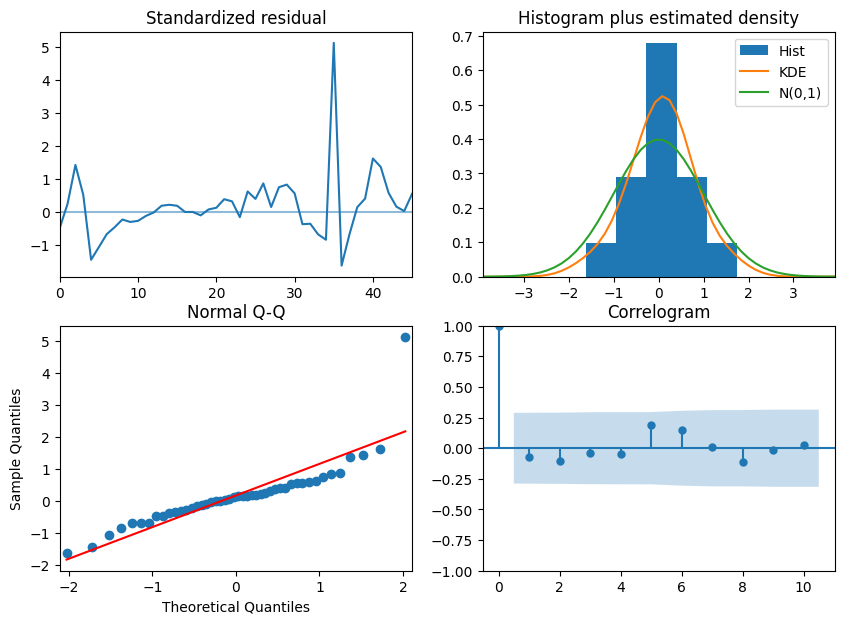

In [25]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [26]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['PE ratio'], order=(0,1,1), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.453555,0.500652
2,0.990732,0.609348
3,0.991142,0.803395
4,1.039490,0.903750
5,1.966223,0.853799
6,2.541968,0.863741
7,2.556398,0.922791
8,3.531923,0.896698
9,3.581114,0.936762
10,3.587222,0.964053


### Residuals are observed values of iid RVs

In [27]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-27-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [28]:
# Differencing the data seasonally
df_diff2 = np.diff(df['PE ratio'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.166216763908147
p-value: 0.0007512435954135179
Critical Values 1%: -3.60098336718852
Critical Values 5%: -2.9351348158036012
Critical Values 10%: -2.6059629803688282


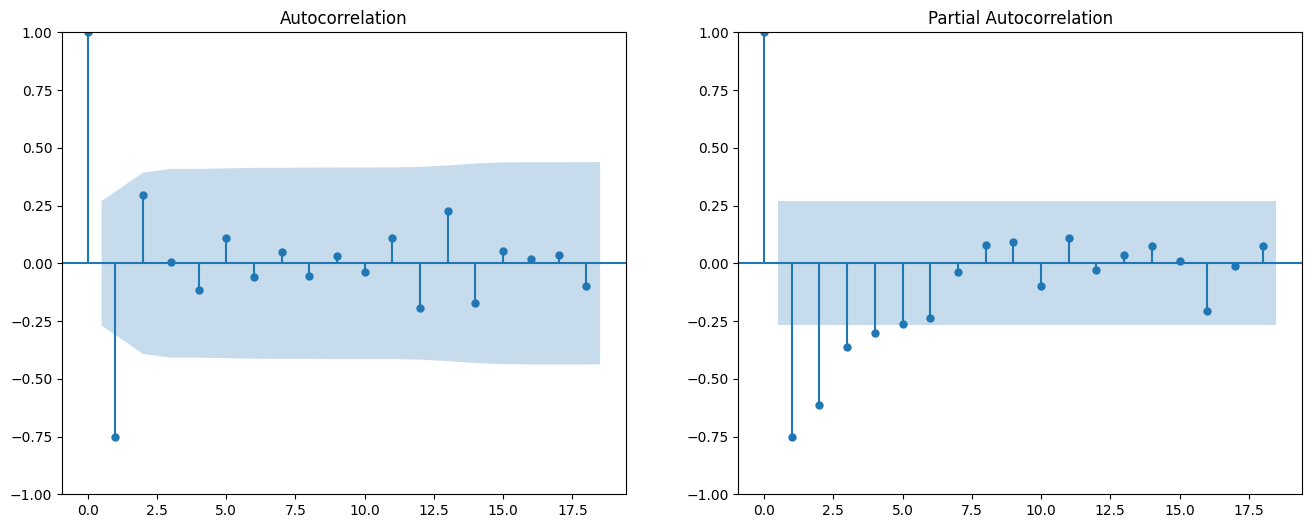

In [29]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [30]:
SARIMA_model = pm.auto_arima(train["PE ratio"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=1,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=191.973, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=206.313, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=199.115, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=188.850, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=204.415, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=186.934, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=188.872, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=190.030, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=188.910, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=188.903, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=197.454, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=189.351, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[4]             : AIC=186.869, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=188.852, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=188.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -91.434
Date:                Thu, 18 Jul 2024   AIC                            186.869
Time:                        14:20:38   BIC                            190.526
Sample:                             0   HQIC                           188.239
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7011      0.121     -5.781      0.000      -0.939      -0.463
sigma2         3.0735      0.299     10.264      0.000       2.487       3.660
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               304.90
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               5.31   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(0,1,1)(0,0,0)[4]

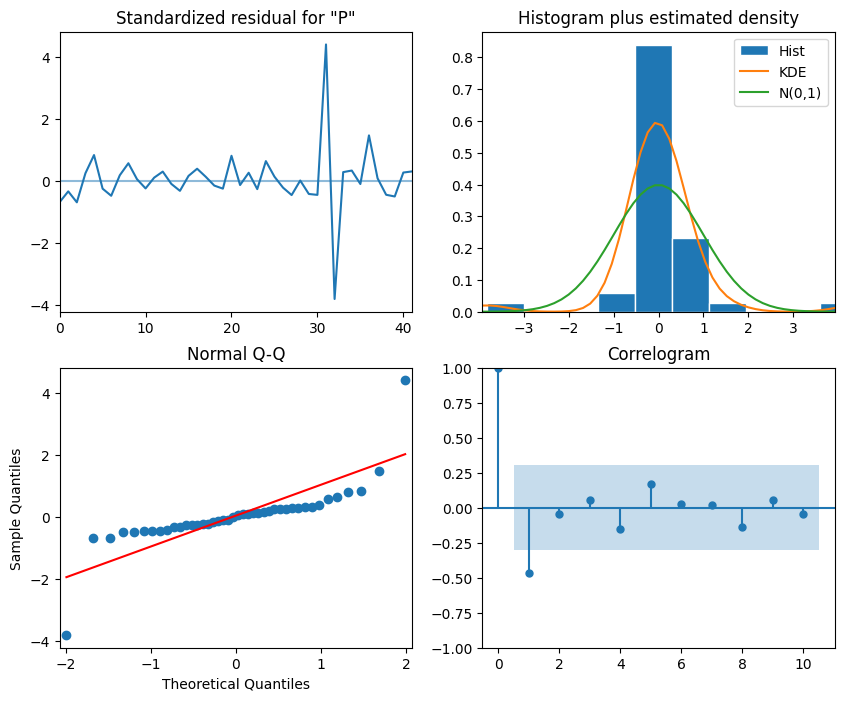

In [31]:
SARIMA_model = SARIMAX(train["PE ratio"], order=(0,1,0), seasonal_order=(0,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [32]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,8.638279,0.003292
2,8.847011,0.011992
3,9.195929,0.026796
4,10.897283,0.027743
5,11.564216,0.041272
6,11.682744,0.069432
7,11.684179,0.111435
8,12.821495,0.118141
9,13.088738,0.158632
10,13.178218,0.213877


### Residuals are observed values if IID RVs

In [33]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-33-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [34]:
# Fit GARCH model to the training set
garch_model = arch_model(train['PE ratio'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [35]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-35-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [36]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=206.313, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=197.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186.934, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=204.415, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=188.910, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=188.903, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=189.351, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=186.869, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=188.803, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=188.778, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=195.736, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=187.648, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.675 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -91.434
Date:                Thu, 18 Jul 2024   AIC                            186.869
Time:                        14:22:05   BIC                            190.526
Sample:                             0   HQIC                           188.239
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7011      0.121     -5.781      0.000      -0.939      -0.463
sigma2         3.0735      0.299     10.264      0.000       2.487       3.660
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               304.90
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               5.31   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-37-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [38]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['PE ratio']])
test_scaled = scaler.transform(test[['PE ratio']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['PE ratio']])

In [39]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [40]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [41]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
42/42 [==============================] - 5s 6ms/step - loss: 0.0539
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0306
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0302
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0275
Epoch 8/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 11/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 12/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 13/100
42/42 [=================

In [42]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 22ms/step


In [43]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-43-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


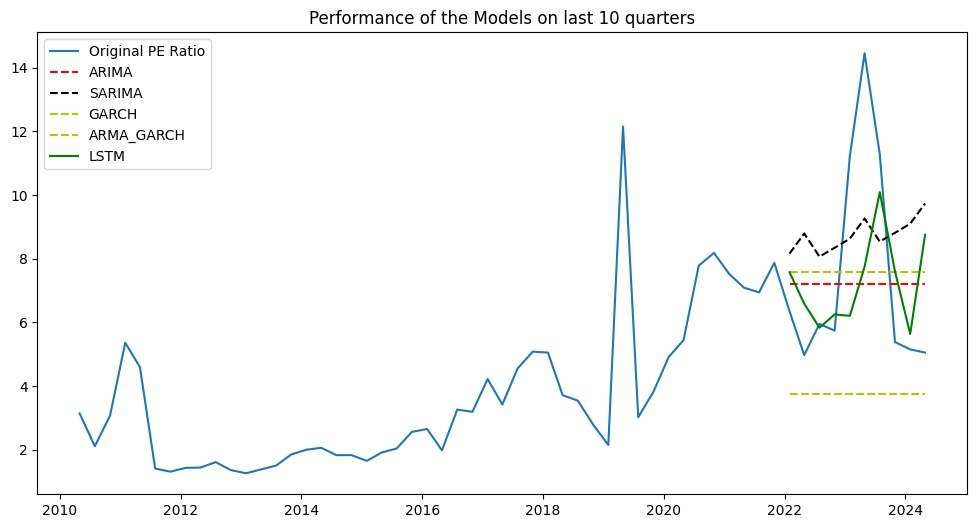

In [44]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  'k--', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

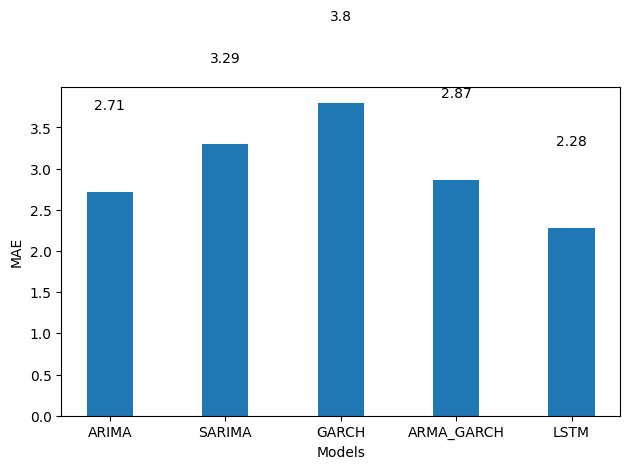

In [45]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['PE ratio'], test['ARIMA_pred'])
mae_SARIMA = mae(test['PE ratio'], test['SARIMA_pred'])
mae_GARCH = mae(test['PE ratio'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['PE ratio'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['PE ratio'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 22ms/step
Forecasted PE Ratios for the next 20 quarters:
[7.575007  7.2194395 6.9236035 6.8734617 7.0193677 6.962389  6.815138
 6.672044  6.606663  6.592233  6.5469856 6.4725766 6.3960958 6.33963
 6.297983  6.2537737 6.203669  6.153444  6.108657  6.0686994]


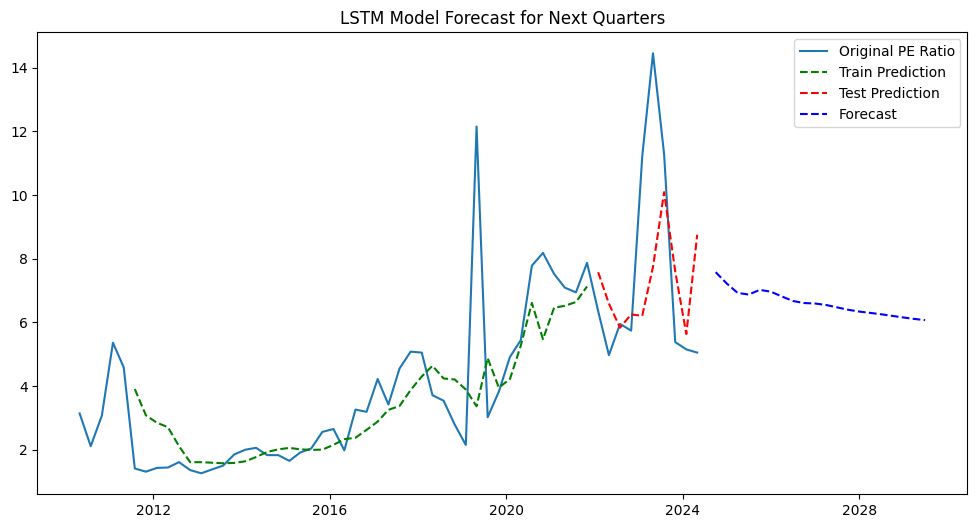

In [46]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()

# ROE

In [60]:
url = 'https://www.macrotrends.net/stocks/charts/NVDA/nvidia/roe'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()  # Ensure we notice bad responses
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df.rename(columns={0 : 'Date', 1 : 'TTMNI', 2 : 'SE', 3 : 'ROE'})
df.set_index('Date', inplace = True)
df = df.iloc[1:len(df['ROE'])-2, :]
df['ROE'] = df['ROE'].str.replace('%', '').astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['ROE'])
df.head(5)

,Date,TTMNI,SE,ROE
52,2023-04-30,$4.79B,$24.52B,20.88
53,2023-07-31,$10.33B,$27.50B,43.26
54,2023-10-31,$18.89B,$33.27B,70.35
55,2024-01-31,$29.76B,$42.98B,92.81
56,2024-04-30,$42.60B,$49.14B,111.45


                                Date         ROE
count                             57   57.000000
mean   2017-04-30 20:37:53.684210432   28.098070
min              2010-04-30 00:00:00    7.620000
25%              2013-10-31 00:00:00   12.320000
50%              2017-04-30 00:00:00   23.760000
75%              2020-10-31 00:00:00   38.650000
max              2024-04-30 00:00:00  111.450000
std                              NaN   20.686316


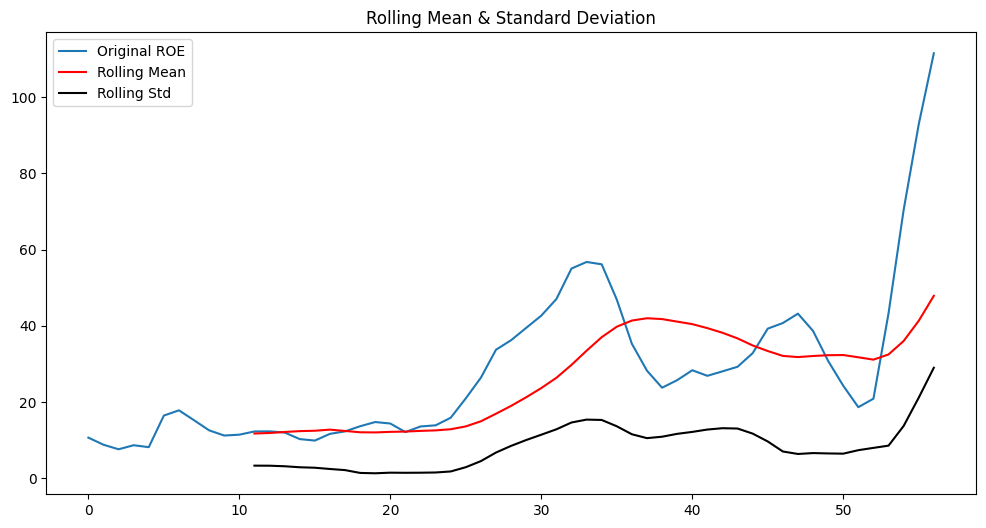

In [61]:
# EDA

# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['ROE'].rolling(window=rolling_window).mean()
rolling_std = df['ROE'].rolling(window=rolling_window).std()

plt.plot(df['ROE'], label='Original ROE')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

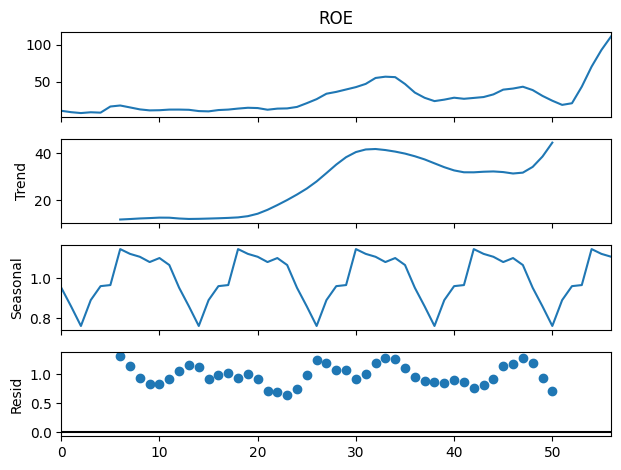

In [62]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['ROE'], model='multiplicative', period=12)
result.plot()
plt.show()

In [63]:
# Check for stationarity
result = adfuller(df['ROE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -0.11166168555392199
p-value: 0.948264525226596
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


In [64]:
# Difference the series to make it stationary
df['ROE diff'] = df['ROE'].diff().dropna()
result = adfuller(df['ROE diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -2.1176004337957703
p-value: 0.23749652393201537
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


In [65]:
# Difference the series to make it stationary
df['ROE diff'] = df['ROE diff'].diff().dropna()
result = adfuller(df['ROE diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -6.203313199933484
p-value: 5.737029897436829e-08
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


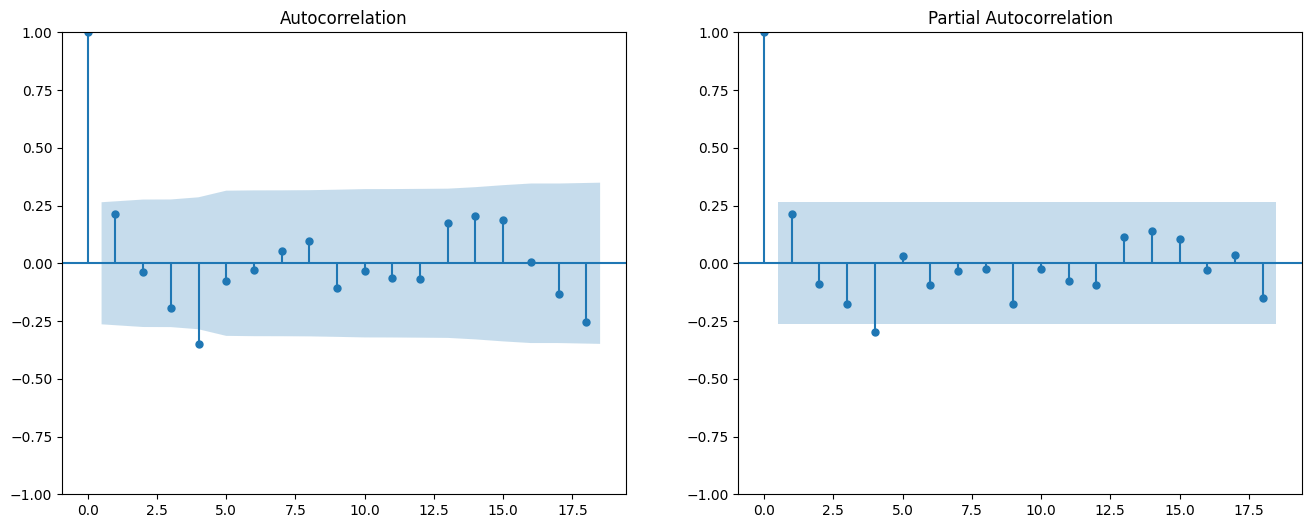

In [66]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['ROE diff'].dropna(), ax=axes[0])
plot_pacf(df['ROE diff'].dropna(), ax=axes[1])
plt.show()

In [67]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [68]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=258.336, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=237.334, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241.121, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257.648, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=238.062, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=238.592, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=235.608, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=236.405, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=236.896, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=239.865, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.789 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -115.804
Date:                Thu, 18 Jul 2024   AIC                            235.608
Time:                        14:36:51   BIC                            239.265
Sample:                             0   HQIC                           236.978
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6323      0.106      5.986      0.000       0.425       0.839
sigma2         8.8993      1.463      6.084      0.000       6.033      11.766
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 4.13
Prob(Q):                              0.48   Prob(JB):                         0.13
Heteroskedasticity (H):               1.97   Skew:                            -0.20
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(1, 1, 0)

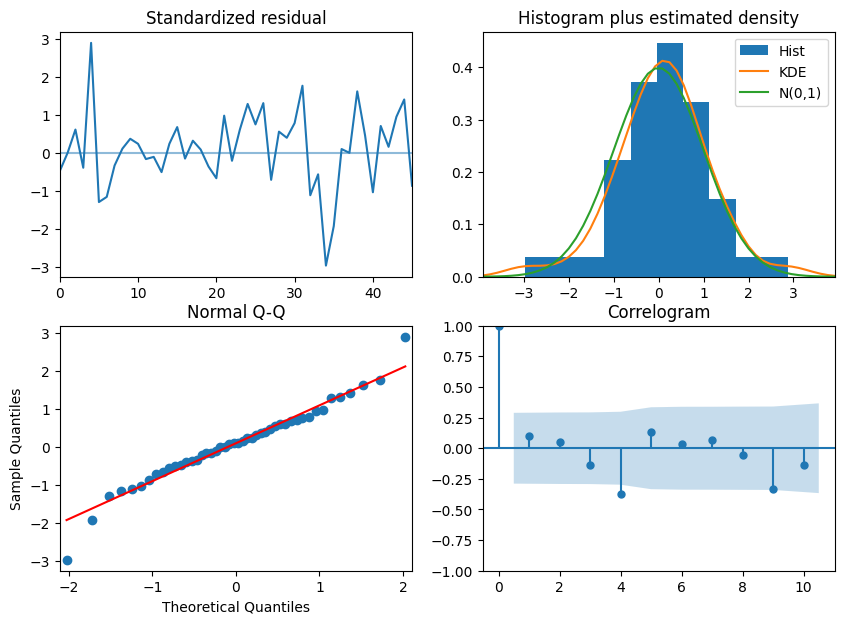

In [69]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [70]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['ROE'], order=(1,1,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.061320,0.804421
2,0.114081,0.944556
3,0.403673,0.939483
4,6.205098,0.184346
5,10.348204,0.065949
6,10.507323,0.104850
7,10.531134,0.160418
8,10.778463,0.214571
9,14.904022,0.093606
10,15.445036,0.116659


### Observed residuals are from IID distribution

In [71]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-71-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [72]:
# Differencing the data seasonally
df_diff2 = np.diff(df['ROE'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.667631363077225
p-value: 9.675875862490393e-05
Critical Values 1%: -3.5925042342183704
Critical Values 5%: -2.931549768951162
Critical Values 10%: -2.60406594375338


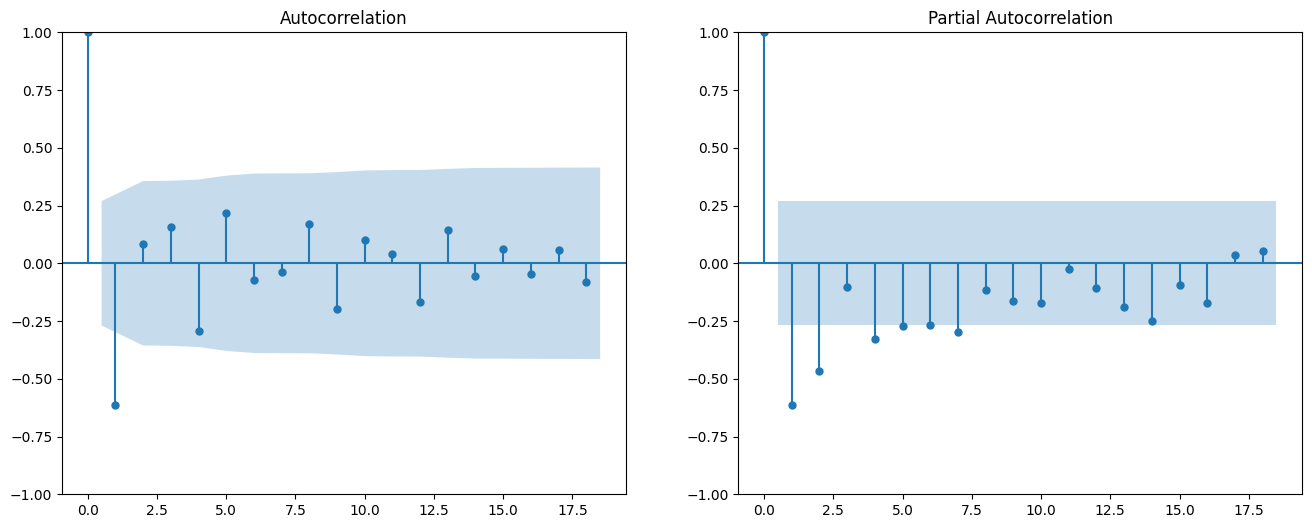

In [73]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [74]:
SARIMA_model = pm.auto_arima(train["ROE"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=258.336, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=231.466, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=257.648, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=237.334, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=230.045, Time=0.19 sec
 ARIMA(1,1,0)(3,0,0)[4] intercept   : AIC=230.868, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(3,0,1)[4] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=254.729, Time=0.07 sec
 ARIMA(2,1,0)(2,0,0)[4] intercept   : AIC=232.016, Time=0.12 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=232.023, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : AIC=238.754, Time=0.12 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   47
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 4)   Log Likelihood                -109.361
Date:                             Thu, 18 Jul 2024   AIC                            224.722
Time:                                     14:37:59   BIC                            230.208
Sample:                                          0   HQIC                           226.778
                                              - 47                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7865      0.095      8.297      0.000       0.601       0.972
ma.S.L4       -0.7596      0.156     -4.883      0.000      -1.064      -0.455
sigma2         6.2728      1.404      4.469      0.000       3.522       9.024
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.59   Prob(JB):                         0.95
Heteroskedasticity (H):               0.69   Skew:                             0.03
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best Model ARIMA(1, 1, 0)(0, 0, 1)[4]

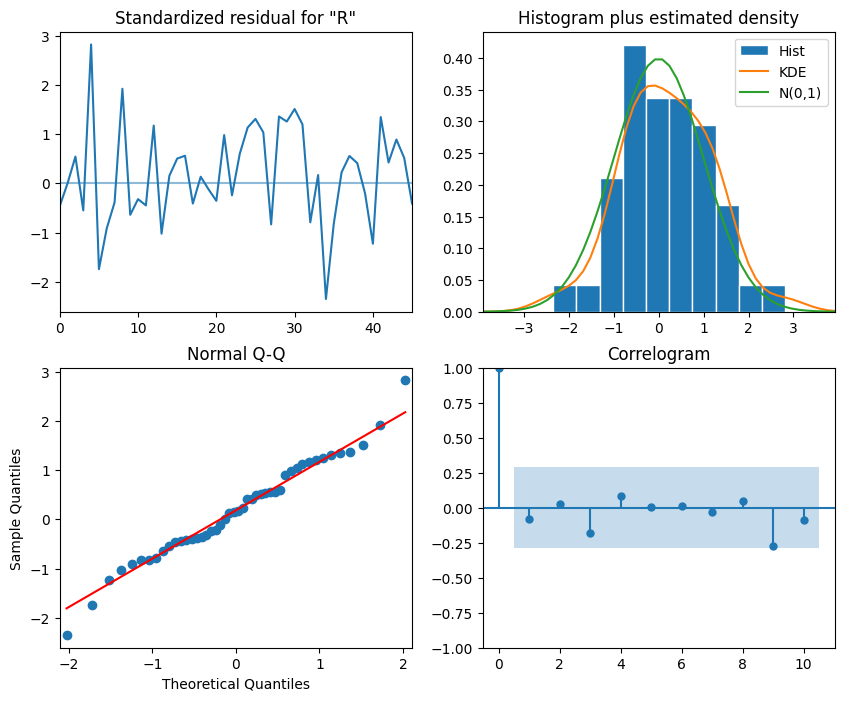

In [75]:
SARIMA_model = SARIMAX(train["ROE"], order=(1,1,0), seasonal_order=(0,0,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [76]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.989736,0.319807
2,0.989745,0.609649
3,1.590625,0.661517
4,1.596888,0.809351
5,3.635506,0.602990
6,4.319440,0.633533
7,4.862843,0.676697
8,4.863263,0.772086
9,5.254975,0.811539
10,5.994648,0.815713


In [77]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-77-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [78]:
# Fit GARCH model to the training set
garch_model = arch_model(train['ROE'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [79]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-79-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [80]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=258.336, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=237.334, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241.121, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257.648, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=238.062, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=238.592, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=235.608, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=236.405, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=236.896, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=239.865, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.788 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -115.804
Date:                Thu, 18 Jul 2024   AIC                            235.608
Time:                        14:39:24   BIC                            239.265
Sample:                             0   HQIC                           236.978
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6323      0.106      5.986      0.000       0.425       0.839
sigma2         8.8993      1.463      6.084      0.000       6.033      11.766
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 4.13
Prob(Q):                              0.48   Prob(JB):                         0.13
Heteroskedasticity (H):               1.97   Skew:                            -0.20
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-81-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [82]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['ROE']])
test_scaled = scaler.transform(test[['ROE']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['ROE']])

In [83]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [84]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [85]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
42/42 [==============================] - 4s 8ms/step - loss: 0.0845
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0454
Epoch 3/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0454
Epoch 4/100
42/42 [==============================] - 0s 7ms/step - loss: 0.0392
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0409
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 8/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0444
Epoch 11/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0359
Epoch 12/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 13/100
42/42 [=================

In [86]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 22ms/step


In [87]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-87-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


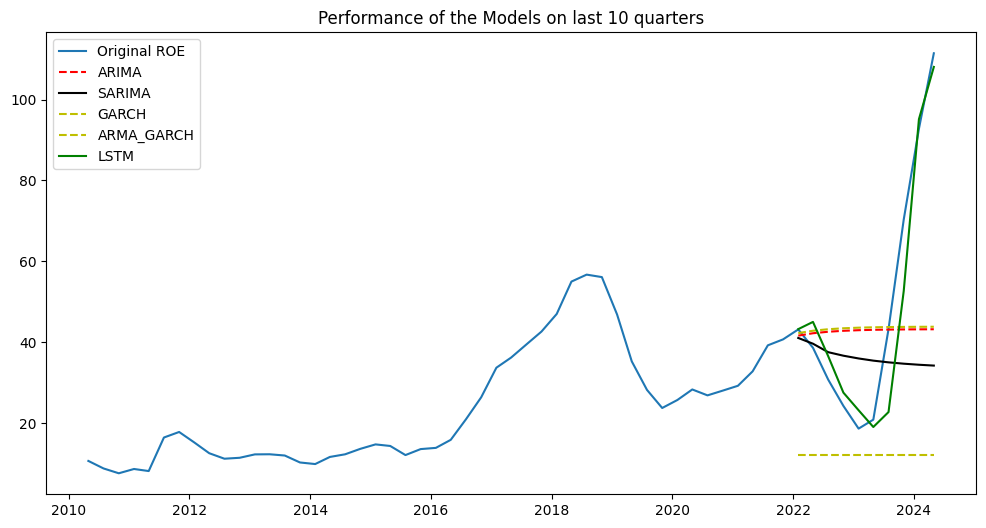

In [88]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['ROE'], label='Original ROE')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  color = 'black', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

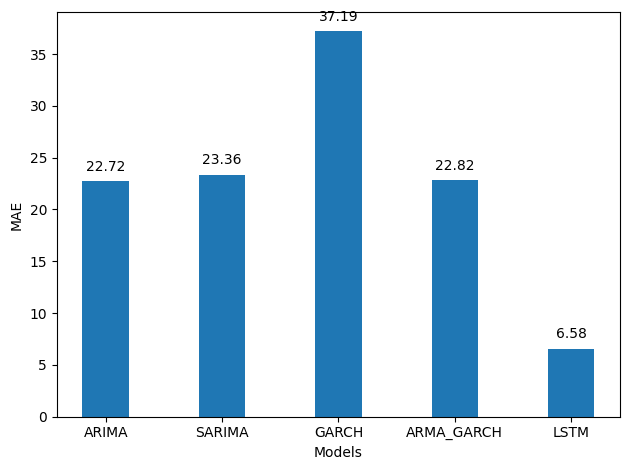

In [89]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['ROE'], test['ARIMA_pred'])
mae_SARIMA = mae(test['ROE'], test['SARIMA_pred'])
mae_GARCH = mae(test['ROE'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['ROE'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['ROE'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 26ms/step
Forecasted PE Ratios for the next 20 quarters:
[43.255993 45.1577   46.39988  46.670563 45.869015 44.205063 42.157677
 40.29911  39.052464 38.575172 38.80277  39.559803 40.64174  41.84594
 42.975563 43.844738 44.3007   44.26176  43.75356  42.917076]


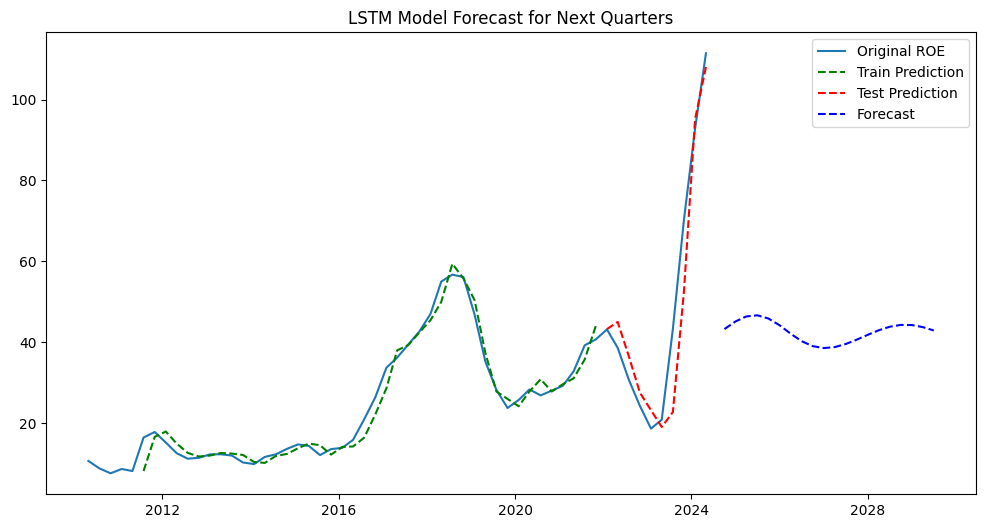

In [91]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ROE'], label='Original ROE')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()